<a href="https://colab.research.google.com/github/ana-rlopez/ny_taxi_fare_prediction/blob/master/NYTaxiFare_1_ExploratoryAnalysis_%26_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from geopy.distance import vincenty
import sklearn.feature_selection
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score

In [33]:
#from google.colab import drive
#drive.mount('/content/drive')
#train_path = '/content/drive/My Drive/Colab Notebooks/train.csv'
train_path = 'train.csv'

In [34]:
train = pd.read_csv(train_path, nrows=1_000_000) #we don't select all rows, since it is a big dataset
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [35]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [36]:
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [37]:
train['key'] = pd.to_datetime(train['key'])
train.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_datetime              object
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [38]:
#add features related with datetime
train['weekday'] = train['key'].dt.dayofweek

train['year']=train['key'].dt.year
train['month']=train['key'].dt.month
train['day']=train['key'].dt.day
train['hour']=train['key'].dt.hour
#train['minute']=train['key'].dt.minute #needed?
#train['second']=train['key'].dt.second

In [39]:
#check if there are some NaN values
train.columns[train.isna().any()].tolist()

['dropoff_longitude', 'dropoff_latitude']

In [40]:
#we drop these values given that the data set is quite big
#original rows: 1_000_000
train.dropna(inplace=True)
train.shape[0]

999990

In [41]:
#drop duplicates
train.drop_duplicates(keep = 'first', inplace = True)
train.shape[0]

999990

In [42]:
train.describe()
#check the describe to see if their values make sense

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941,3.039870,2011.741103,6.267841,15.697996,13.509463
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907,1.949966,1.860761,3.436230,8.682472,6.513855
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000,1.000000,2010.000000,3.000000,8.000000,9.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000,3.000000,2012.000000,6.000000,16.000000,14.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000,5.000000,2013.000000,9.000000,23.000000,19.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000,6.000000,2015.000000,12.000000,31.000000,23.000000


In [43]:
#based on these descriptors, we can at first sight already remove some outliers:
#1) Latitudes range from -90 to 90. Longitudes range from -180 to 180.
#2) passengers in a taxi, up to 6 (icnluding suvs) https://ride.guru/lounge/p/how-many-people-can-ride-in-a-cab 
#leave drives of 0 passengers in case documents are transported?
#3) fare has to be positive value, over 2.50$? (that seems to be the initial charge) https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page
#also fare now seems too high (500) and the variance is pretty hight too. so we cut the max fare now

#4) new york city actually has the following bounding box of coordinates (https://boundingbox.klokantech.com/)
eastlimit_longitude=-73.700181
southlimit_latitude =40.47739894
westlimit_longitude=-74.25909
northlimit_latitude=40.916178         
                                                                                                               
train = train[ (train.pickup_longitude >= westlimit_longitude) & (train.pickup_longitude <= eastlimit_longitude) & \
              (train.dropoff_longitude >= westlimit_longitude) & (train.dropoff_longitude <= eastlimit_longitude) & \
              (train.pickup_latitude >= southlimit_latitude ) & (train.pickup_latitude <= northlimit_latitude) & \
              (train.dropoff_latitude >= southlimit_latitude) & (train.dropoff_latitude <= northlimit_latitude) & \
              (train.passenger_count<= 6) & \
              (train.fare_amount >= 2.50) & \
             (train.fare_amount < 150)]                                                                                    

#train = train[ (train.pickup_longitude >= -180) & (train.pickup_longitude <= 180) & \
#              (train.dropoff_longitude >= -180) & (train.dropoff_longitude <= 180) & \
#              (train.pickup_latitude >= -90) & (train.pickup_latitude <= 90) & \
#              (train.dropoff_latitude >= -90) & (train.dropoff_latitude <= 90) & \
#              (train.passenger_count<= 6) & \
#              (train.fare_amount > 2.50)  ]
    


In [44]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour
count,977797.000000,977797.000000,977797.000000,977797.000000,977797.000000,977797.000000,977797.000000,977797.000000,977797.000000,977797.000000,977797.000000
mean,11.282636,-73.975496,40.750867,-73.974580,40.751212,1.685226,3.039659,2011.739740,6.268979,15.692753,13.509817
std,9.385991,0.034410,0.026851,0.033898,0.030729,1.307926,1.949787,1.863172,3.437944,8.683000,6.510824
min,2.500000,-74.258821,40.482543,-74.258579,40.479537,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000
25%,6.000000,-73.992275,40.736583,-73.991575,40.735589,1.000000,1.000000,2010.000000,3.000000,8.000000,9.000000
50%,8.500000,-73.982092,40.753400,-73.980608,40.753857,1.000000,3.000000,2012.000000,6.000000,16.000000,14.000000
75%,12.500000,-73.968362,40.767542,-73.965393,40.768394,2.000000,5.000000,2013.000000,9.000000,23.000000,19.000000
max,149.540000,-73.700438,40.913110,-73.700390,40.916035,6.000000,6.000000,2015.000000,12.000000,31.000000,23.000000


In [45]:
#maybe convert time (hours and minutes) to circular, given that then the correlation may be more easily seen
#seconds_in_day = 24*60*60

#train['full_time'] = train.hour*60*60 + train.minute*60 + train.second #time of the day in seconds
#train['sin_time'] = np.sin(2*np.pi*train.full_time/seconds_in_day)
#train['cos_time'] = np.cos(2*np.pi*train.full_time/seconds_in_day)
#train.drop('full_time', axis=1, inplace=True)

#note: checked that these 2 feats are computed ok (proper ranges)

In [63]:
#Instead of doing Harvestine distance (that assumes Earth is a sphere), here Vincenty distance is used,
#which employs more accurate ellipsoidal models

# (latitude, longitude) reminder
train ['distance'] = train.apply(lambda x: vincenty((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).kilometers, axis = 1)

/home/a/miniconda2/envs/kernpy3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  """


In [64]:
train['distance'].describe()

count    967625.000000
mean          3.340551
std           3.548214
min           0.000084
25%           1.278906
50%           2.176131
75%           3.942641
max          45.695455
Name: distance, dtype: float64

In [65]:
train.describe().loc[['min','max']]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour,distance,distance_log
min,2.50,-74.258821,40.482543,-74.258579,40.479537,0.0,0.0,2009.0,1.0,1.0,0.0,0.000084,-2.473561
max,149.54,-73.702142,40.912843,-73.700390,40.916035,6.0,6.0,2015.0,12.0,31.0,23.0,45.695455,10.729754


In [66]:
#there shouldn't be any distance equal to 0:
train = train[ (train.distance > 0)]
#log transform for distance helps
train['distance_log'] = train['distance'].transform(lambda x: np.log(x+sys.float_info.epsilon))

In [67]:
train.shape

(967625, 15)

/home/a/miniconda2/envs/kernpy3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f28a7817588>,
      dtype=object)

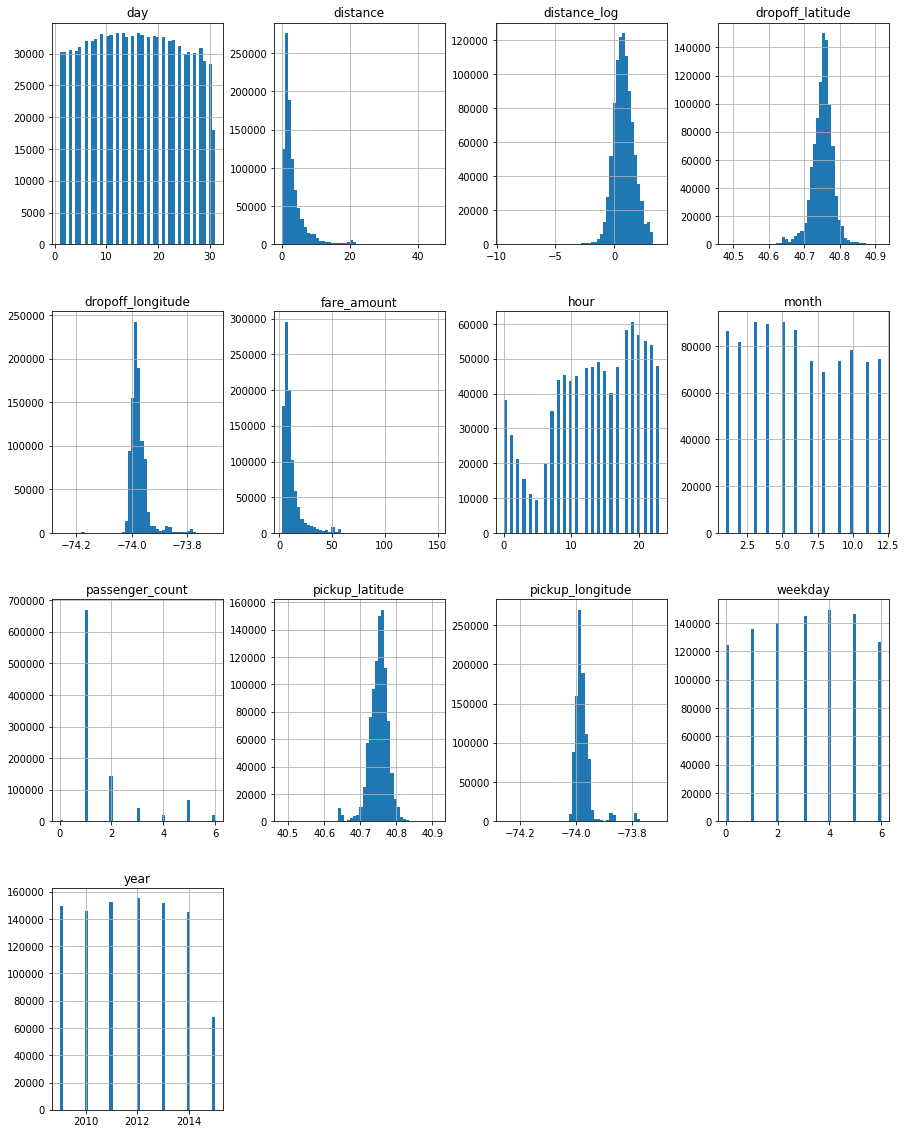

In [68]:
#check distributions of all the features
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train.hist(ax = ax, bins=50)


In [69]:
#Outlier removal, probably not needed

#Q1 = train.quantile(0.25)
#Q3 = train.quantile(0.75)
#IQR = Q3 - Q1

##automatic outlier removal, to try and get more normal distributions
##https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba?gi=8548f80fce4b
#train_out = train.drop(['key','pickup_datetime'],axis=1, inplace=False)
#
#train_out = train_out[~((train_out < (Q1 - 1.5 * IQR)) |(train_out > (Q3 + 1.5 * IQR))).any(axis=1)]

In [70]:
corr_pearson = train.corr(method='pearson')
mask = np.zeros_like(corr_pearson, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

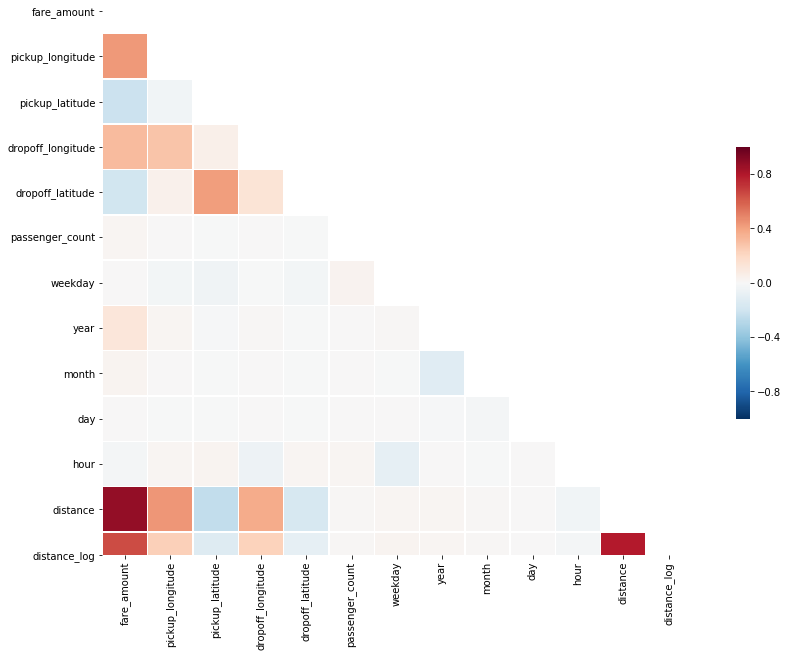

In [71]:
fig4, ax4 = plt.subplots(figsize=(16, 10))
sns.heatmap(corr_pearson, mask=mask, cmap='RdBu_r', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},vmin=-1)

In [72]:
#visualizer = FeatureCorrelation( method='mutual_info-classification', feature_names=train_out.columns, sort=True)
X = train.drop(['fare_amount','key','pickup_datetime'],axis=1, inplace=False).to_numpy()
Y = train.fare_amount.to_numpy()
#lab_enc = sklearn.preprocessing.LabelEncoder()
#Y_encoded = lab_enc.fit_transform(Y)

#mutual information has too expensive computationally to run for all data, so we just take 
X = X[1:100000,:]
Y = Y[1:100000]

feature_MIscores = sklearn.feature_selection.mutual_info_regression(X, Y)

#visualizer.fit(X, Y)        # Fit the data to the visualizer
#visualizer.show()              # Finalize and render the figure

In [73]:
feature_MIscores.shape

#plot also the fare vs the date (year), and maybe check as hypothesis if there is a positive correlation between year and fare

(12,)

([<matplotlib.axis.YTick at 0x7f28a6c12518>,
 <a list of 12 Text yticklabel objects>)

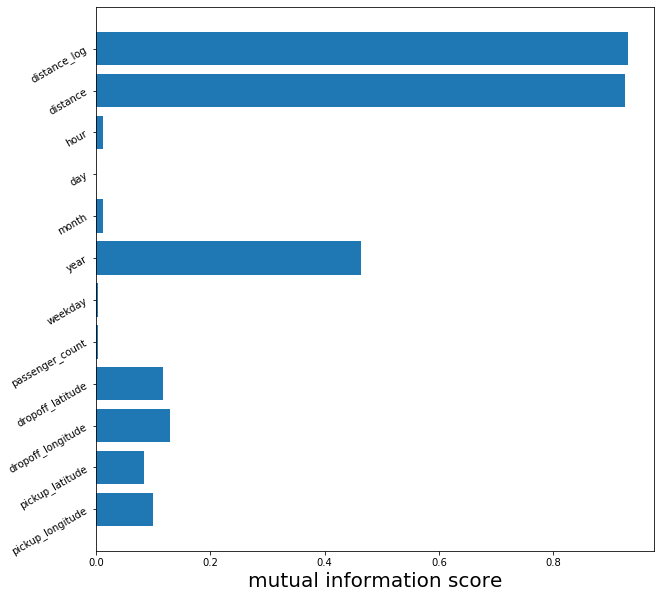

In [74]:
feats_labels = train.drop(['fare_amount','key','pickup_datetime'],axis=1, inplace=False).columns
#print(feats_labels)
index = np.arange(len(feats_labels))
plt.figure(figsize=(10,10))
plt.barh(index, feature_MIscores)
plt.xlabel('mutual information score', fontsize=20)
plt.yticks(index, feats_labels, fontsize=10, rotation=30)

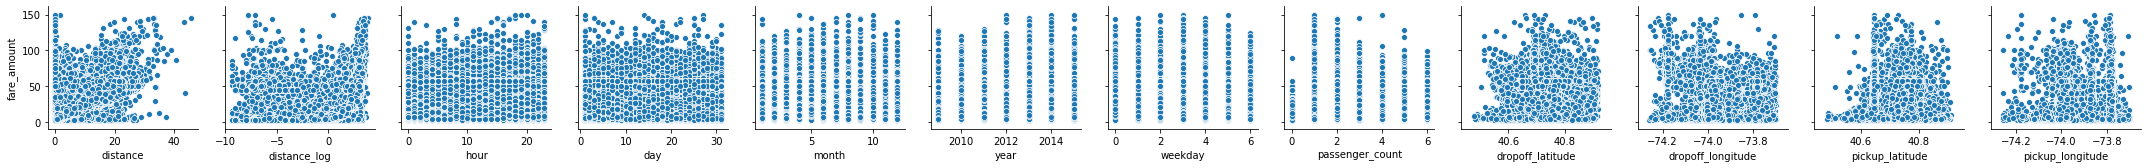

In [91]:
#sns.pairplot(train, y_vars=['fare_amount'], x_vars=['distance', 'distance_log', 'hour','day','month','year','weekday','passenger_count','dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude'])

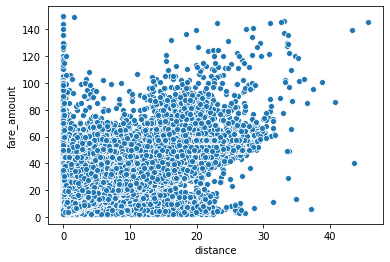

In [83]:
sns.scatterplot(x="distance", y="fare_amount", data=train)

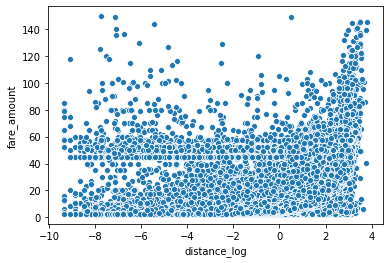

In [84]:
#there is also a kind of straight line, that can be explained by the flat rates used for taxi rides from airport
 #"Taxis at JFK Airport charge a flat fare of $52 for trips between the airport and Manhattan." 
#https://www.jfkairport.com/to-from-airport/taxi-car-and-van-service
sns.scatterplot(x="distance_log", y="fare_amount", data=train)

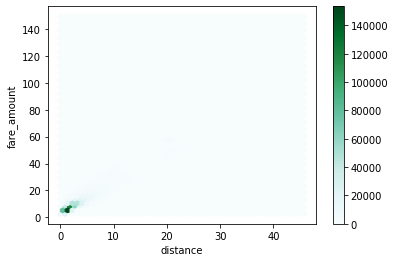

In [79]:
#using hex bins because regular scatter plot does not work (too many points)
train.plot.hexbin(x='distance', y='fare_amount', gridsize=50, reduce_C_function=np.sum, sharex=False)

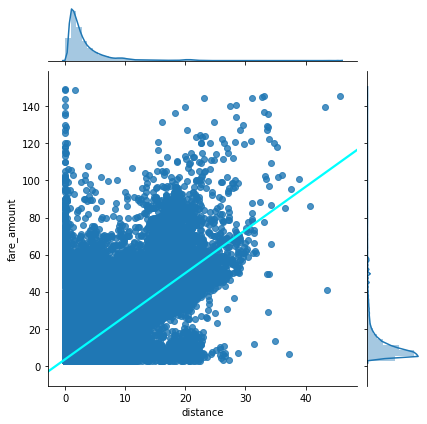

In [96]:
#using hex bins because regular scatter plot does not work (too many points)
sns.jointplot(x="distance", y="fare_amount", data=train, kind='reg',joint_kws={'line_kws':{'color':'cyan'}})

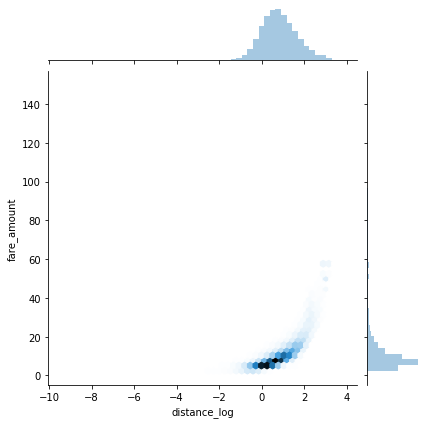

In [95]:
#using hex bins because regular scatter plot does not work (too many points)
#easier to see with dostance_log since the scale is shrunk
sns.jointplot(x="distance", y="fare_amount", data=train, kind='hex')

In [ ]:
#TODO: maybe also plot histograms grouping by day, or by hour, to see what times are more common, and see if the fair is similar for 

In [ ]:
#TODO:maybe a heat map of the fares would be interesting, doing a geomap, maybe use plotly?

In [ ]:
#TODO: maybe employ clustering to get some extra information of the data, like outliers? 

We apply the models. 1) Linear regression

In [ ]:
val = pd.read_csv(train_path, skiprows=[2, 1_000_000], nrows=400_000)
val.head()

In [ ]:
val.shape

In [ ]:
val.columns[val.isna().any()].tolist()

In [ ]:
#now we add the same features that we did previously:
val['key'] = pd.to_datetime(val['key'])
val['weekday'] = val['key'].dt.dayofweek
val['year']=val['key'].dt.year
val['month']=val['key'].dt.month
val['day']=val['key'].dt.day
val['hour']=val['key'].dt.hour

#drop other
val.drop(['key','pickup_datetime'],axis=1, inplace=True)

In [ ]:
val.columns[val.isna().any()].tolist()

In [ ]:
#we don't remove NaN observations in the valiation test, because we want to be able to check how good it is 
#with all entries
#we use median rather than mean since it is more robust against outliers
val.dropoff_longitude.fillna(val.dropoff_longitude.median(),inplace=True)
val.dropoff_latitude.fillna(val.dropoff_latitude.median(),inplace=True)

In [ ]:
#bounding the wrong coordinates (for distance computation)
val.loc[val['pickup_longitude'] > 180, 'pickup_longitude'] = 180
val.loc[val['pickup_longitude'] < -180, 'pickup_longitude'] = -180
val.loc[val['dropoff_longitude'] > 180, 'dropoff_longitude'] = 180
val.loc[val['dropoff_longitude'] < -180, 'dropoff_longitude'] = -180

val.loc[val['pickup_latitude'] > 90, 'pickup_latitude'] = 90
val.loc[val['pickup_latitude'] < -90, 'pickup_latitude'] = -90
val.loc[val['dropoff_latitude'] > 90, 'dropoff_latitude'] = 90
val.loc[val['dropoff_latitude'] < -90, 'dropoff_latitude'] = -90



In [ ]:
val.describe()

In [ ]:
#Instead of doing Harvestine distance (that assumes Earth is a sphere), here Vincenty distance is used,
#which employs more accurate ellipsoidal models

# (latitude, longitude) reminder
val ['distance'] = val.apply(lambda y: vincenty((y['pickup_latitude'], y['pickup_longitude']), (y['dropoff_latitude'], y['dropoff_longitude'])).meters, axis = 1)

In [ ]:
val.describe()

In [ ]:
#to normalize we use a robust scaler against outliers
robustScaler_val = RobustScaler().fit(val)
val_norm_array = robustScaler_val.transform(val)
val_norm = pd.DataFrame(val_norm_array, columns=val.columns)

#normalize data:
#val_norm=(val-val.mean())/val.std()
#train_norm = (train-train.mean())/train.std()

In [ ]:
val_norm.describe()

In [ ]:
robustScaler_train_out = RobustScaler().fit(train_out)
train_outnorm_array = robustScaler_train_out.transform(train_out)
train_outnorm = pd.DataFrame(train_outnorm_array, columns=train_out.columns)

In [ ]:
train_outnorm.describe()

In [ ]:
# create linear regression model
linRegr = linear_model.LinearRegression()

#data
x_train = train_outnorm[['year', 'distance']].values
y_train1 = train_outnorm.fare_amount.values
y_train = y_train1.reshape(len(y_train1), 1)
x_val = val_norm[['year', 'distance']].values
y_val1 = val_norm.fare_amount.values
y_val = y_val1.reshape(len(y_val1), 1)


x_train.shape


In [ ]:
# train the model with training data
linRegr.fit(x_train, y_train)

In [ ]:
y_pred = linRegr.predict(x_val)

In [ ]:
y_pred.shape

In [ ]:
r2_score(val_norm.fare_amount, y_pred)
print(linRegr_val_r2)

In [ ]:
plt.scatter(x_val[:,1], y_val,  color='black')
plt.plot(x_val[:,1], y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(train_outnorm[['year', 'distance']], train_out.fare_amount)
DummyRegressor()
dummy_regr.predict(val[['year', 'distance']])
dummy_regr.score(X, y)

In [ ]:
val.columns[val.isna().any()].tolist()